# [**Exemple de reconnaissance faciale utilisant des eigenfaces et des SVMs**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/applications/plot_face_recognition.ipynb)<br/>([*Faces recognition example using eigenfaces and SVMs*](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html))

Le jeu de données utilisé dans cet exemple est un extrait prétraité de "Labeled Faces in the Wild", également connu sous le nom de LFW :

http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

In [1]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

Téléchargez les données, si elles ne sont pas déjà sur le disque, et chargez-les en tant que tableaux numpy

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Divisez-les en un ensemble d'entraînement et un ensemble de test et conservez 25% des données pour les tests.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Effectuez une ACP (visages propres) sur le jeu de données de visages (traité comme un jeu de données non étiqueté) : extraction de caractéristiques non supervisée / réduction de dimensionnalité

In [5]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.277s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.045s


Entraînez un modèle de classification SVM

In [6]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 10.207s
Best estimator found by grid search:
SVC(C=15572.960939330285, class_weight='balanced', gamma=0.00225751140196918)


Évaluation quantitative de la qualité du modèle sur l'ensemble de test

Predicting people's names on the test set
done in 0.110s
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.92      0.83        13
     Colin Powell       0.88      0.88      0.88        60
  Donald Rumsfeld       0.69      0.67      0.68        27
    George W Bush       0.90      0.95      0.93       146
Gerhard Schroeder       0.85      0.88      0.86        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.84      0.75      0.79        36

         accuracy                           0.86       322
        macro avg       0.83      0.79      0.80       322
     weighted avg       0.86      0.86      0.86       322



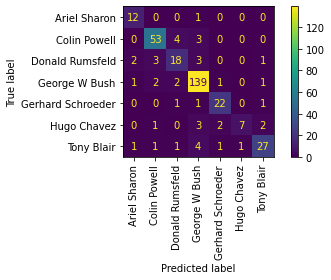

In [7]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Évaluation qualitative des prédictions en utilisant matplotlib

In [8]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

tracer le résultat de la prédiction sur une partie de l'ensemble de test

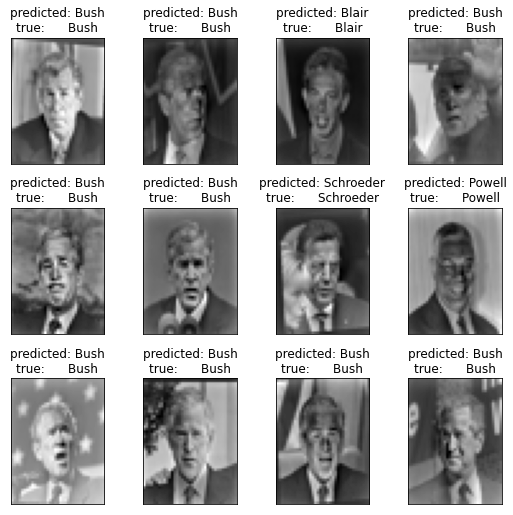

In [9]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_face_recognition_002.png"/>

tracer la galerie des visages propres les plus significatifs

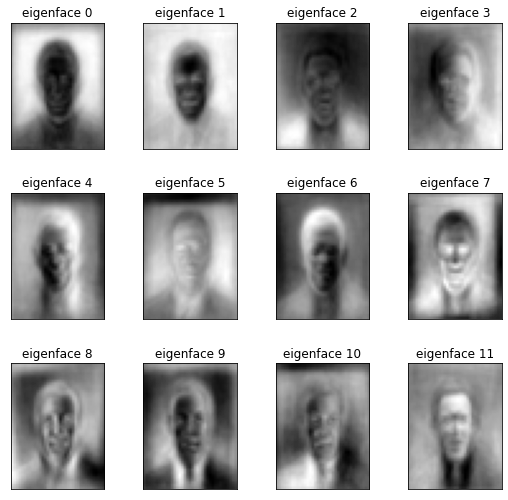

In [10]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

Le problème de reconnaissance faciale serait beaucoup plus efficacement résolu en entraînant des réseaux de neurones à convolution mais cette famille de modèles est en dehors de la portée de la bibliothèque scikit-learn. Les lecteurs intéressés devraient plutôt essayer d'utiliser pytorch ou tensorflow pour implémenter de tels modèles.